In [66]:
%matplotlib inline

width = 6
height = 3
import matplotlib
matplotlib.rcParams['figure.figsize'] = [width, height]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import pdb

import tensorflow as tf

import sklearn
import sklearn.preprocessing

import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr

## Exercise:  Look at the data

In [67]:
## we download historical data from 1990-2019
## from Yahoo https://finance.yahoo.com/quote/%5EGSPC/history?period1=634885200&period2=1550034000&interval=1d&filter=history&frequency=1d

Были взяты данные акций Абрау-Дюрсо за период 2012 - 2024 год

In [68]:
df = pd.read_csv("/kaggle/input/abray-durso/ABRD_D1.csv")
df = df.rename(columns={'datetime': 'Date', 'open': 'Open', 'close': 'Close', 'high': 'High', 'low': 'Low', 'volume': 'Volume'})

In [69]:
df.shape

(2762, 6)

In [70]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2012-04-11,5201.0,5325.0,5170.0,5307.0,228
1,2012-04-12,5300.0,5370.0,5300.0,5335.0,81
2,2012-04-13,5330.0,5340.0,5289.0,5327.0,79
3,2012-04-16,5291.0,5325.0,5291.0,5322.0,56
4,2012-04-17,5320.0,5338.0,5320.0,5332.0,73


In [71]:
df.tail()

,Date,Open,High,Low,Close,Volume
2757,2024-08-21,219.0,222.2,217.2,218.2,9634
2758,2024-08-22,218.4,222.4,215.6,215.6,8605
2759,2024-08-23,215.0,222.6,201.0,203.6,32792
2760,2024-08-26,214.0,216.6,206.4,211.2,12659
2761,2024-08-27,212.4,213.8,204.8,205.8,7169


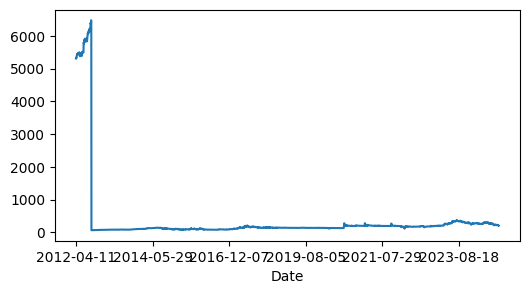

In [72]:
## let's first take a look at our data
df.index = df.Date
fig = df.Close.plot()

<Axes: xlabel='Date'>

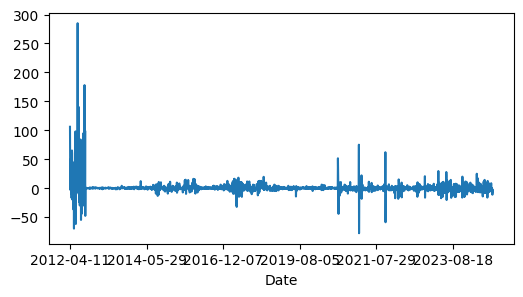

In [73]:
(df.Close - df.Open).plot()

In [74]:
## we can see there have been several "regime changes"
## although it would be difficult to set an exact date of the change
## but do different weeks look all that different?

([<matplotlib.axis.XTick at 0x79c3e5076920>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

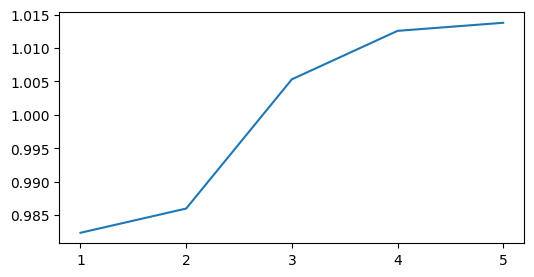

In [75]:
vals = df["2013-05-05":"2013-05-13"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5])

([<matplotlib.axis.XTick at 0x79c3e4ef9f30>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

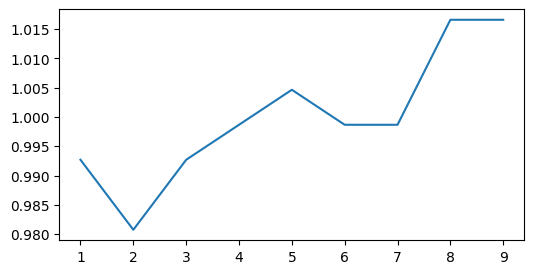

In [76]:
vals = df["2016-05-05":"2016-05-18"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])

([<matplotlib.axis.XTick at 0x79c3e4f6e380>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

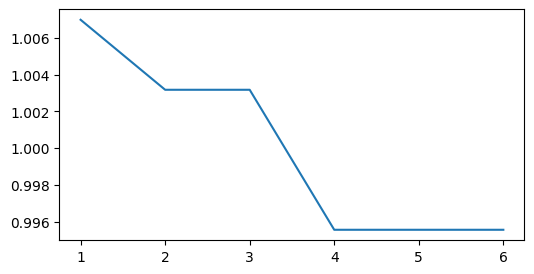

In [77]:
vals = df["2020-05-05":"2020-05-13"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5, 6], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5, 6])

In [78]:
## if we evaluate in terms of percent change within the week 
## none of these weeks seem distinctly different at the week-based scale to the eye

## Data Preprocessing

In [79]:
## We will use a deep learning approach, so we need to normalize our inputs to fall 
## within -1 to 1. we want to do so without letting information leak backwards from the future
## so we need to have a rolling smoothing process rather than taking the global mean to normalize
## these columns

In [80]:
## we want to predict daily returns (imagine you choose only to buy at start of day 
## and sell at end of day)

In [81]:
df.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2012-04-11,2012-04-11,5201.0,5325.0,5170.0,5307.0,228
2012-04-12,2012-04-12,5300.0,5370.0,5300.0,5335.0,81
2012-04-13,2012-04-13,5330.0,5340.0,5289.0,5327.0,79
2012-04-16,2012-04-16,5291.0,5325.0,5291.0,5322.0,56
2012-04-17,2012-04-17,5320.0,5338.0,5320.0,5332.0,73


In [82]:
df['Return'] = df.Close - df.Open

<Axes: xlabel='Date'>

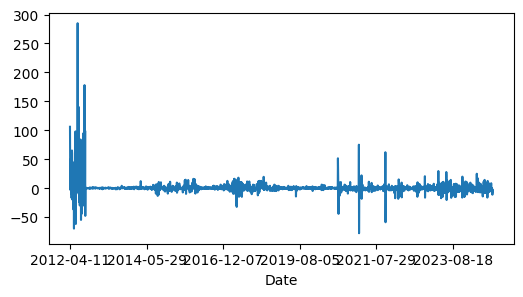

In [83]:
df.Return.plot()

In [84]:
df['DailyVolatility'] = df.High - df.Low

<Axes: xlabel='Date'>

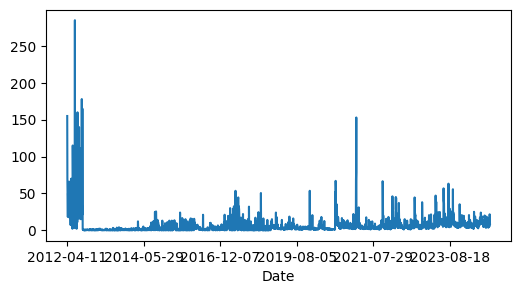

In [85]:
df.DailyVolatility.plot()

In [86]:
## as our inputs we will use daily volatility, daily return, and daily volume
## all should be scaled appropriately so we need to compute rolling means to scale these

In [87]:
## we will use an exponentially weighted moving average

In [88]:
ewdf = df.loc[:, ['Volume', 'Return', 'DailyVolatility']].ewm(halflife = 10).mean()

<Axes: xlabel='Date'>

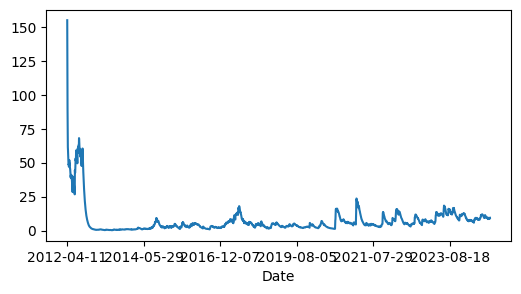

In [89]:
ewdf.DailyVolatility.plot()

In [90]:
vewdf = df.loc[:, ['Volume', 'Return', 'DailyVolatility']].ewm(halflife = 10).var()

<Axes: xlabel='Date'>

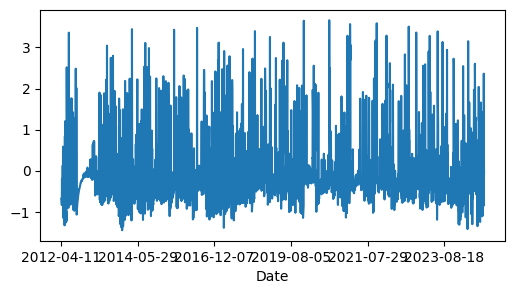

In [91]:
## notice that we don't fit to the smoothed values we merely use them to 
((df.DailyVolatility - ewdf.DailyVolatility)/ vewdf.DailyVolatility**0.5 ).plot()

In [92]:
df['ScaledVolatility'] = ((df.DailyVolatility - ewdf.DailyVolatility)/ vewdf.DailyVolatility**0.5 )

In [93]:
df.head()

,Date,Open,High,Low,Close,Volume,Return,DailyVolatility,ScaledVolatility
Date,,,,,,,,,
2012-04-11,2012-04-11,5201.0,5325.0,5170.0,5307.0,228,106.0,155.0,NaN
2012-04-12,2012-04-12,5300.0,5370.0,5300.0,5335.0,81,35.0,70.0,-0.682610
2012-04-13,2012-04-13,5330.0,5340.0,5289.0,5327.0,79,-3.0,51.0,-0.706703
2012-04-16,2012-04-16,5291.0,5325.0,5291.0,5322.0,56,31.0,34.0,-0.767579
2012-04-17,2012-04-17,5320.0,5338.0,5320.0,5332.0,73,12.0,18.0,-0.836879


In [94]:
df['ScaledReturn'] = ((df.Return - ewdf.Return)/ vewdf.Return**0.5 )

In [95]:
df['ScaledVolume'] = ((df.Volume - ewdf.Volume)/ vewdf.Volume**0.5 )

In [96]:
df.head(12)

,Date,Open,High,Low,Close,Volume,Return,DailyVolatility,ScaledVolatility,ScaledReturn,ScaledVolume
Date,,,,,,,,,,,
2012-04-11,2012-04-11,5201.0,5325.0,5170.0,5307.0,228,106.0,155.0,NaN,NaN,NaN
2012-04-12,2012-04-12,5300.0,5370.0,5300.0,5335.0,81,35.0,70.0,-0.682610,-0.682610,-0.682610
2012-04-13,2012-04-13,5330.0,5340.0,5289.0,5327.0,79,-3.0,51.0,-0.706703,-0.846411,-0.558957
2012-04-16,2012-04-16,5291.0,5325.0,5291.0,5322.0,56,31.0,34.0,-0.767579,-0.202963,-0.661878
2012-04-17,2012-04-17,5320.0,5338.0,5320.0,5332.0,73,12.0,18.0,-0.836879,-0.539315,-0.387293
2012-04-18,2012-04-18,5347.0,5397.0,5347.0,5397.0,70,50.0,50.0,-0.199557,0.365940,-0.386390
2012-04-19,2012-04-19,5384.0,5420.0,5384.0,5420.0,70,36.0,36.0,-0.453609,-0.021781,-0.350593
2012-04-20,2012-04-20,5420.0,5438.0,5403.0,5438.0,70,18.0,35.0,-0.433642,-0.522463,-0.321487
2012-04-23,2012-04-23,5438.0,5438.0,5400.0,5429.0,26,-9.0,38.0,-0.329209,-1.144726,-1.003112


In [97]:
## remove first row, which has na
df = df.dropna()

In [98]:
## now we need to form input arrays and target arrays
## let's try to predict just a day ahead and see how we do
## predicting stock prices is notoriously difficult so we should not
## get ahead of ourselves

In [99]:
train_df = df[:2500]
test_df = df[2500:]
X = train_df[:(2500 - 10)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
Y = train_df[10:]["ScaledReturn"].values

In [100]:
len(Y)

2490

In [101]:
## however batches are usually in form TNC
## time, num examples, channels
## so we need to reshape

In [102]:
X.shape

(2490, 3)

In [103]:
X = np.expand_dims(X, axis = 1)

In [104]:
X.shape

(2490, 1, 3)

## Exercise: reshape X into 'TNC' form with numpy operations

In [105]:
X = np.split(X, X.shape[0]/10, axis = 0)

In [106]:
X = np.concatenate(X, axis = 1)

In [107]:
X.shape

(10, 249, 3)

In [108]:
X[:, 0, 1]

array([-0.68261013, -0.84641125, -0.20296343, -0.53931451,  0.36594035,
       -0.02178131, -0.52246267, -1.14472615, -0.27899233, -1.20053647])

In [109]:
X[:, 1, 1]

array([-0.99111341,  1.18112768,  1.12553803,  0.88375252, -1.16567234,
       -1.12565822,  0.29188472, -0.56552103,  0.45135982, -0.21859963])

In [110]:
X[:, 2, 1]

array([-0.17800621, -0.55067369, -1.61566609,  0.44362087, -0.68658499,
       -2.08493228, -0.18166066,  0.99734837, -0.09237222, -0.71783494])

In [111]:
train_df[:(2500 - 10)][["ScaledReturn"]].values[:31]

array([[-0.68261013],
       [-0.84641125],
       [-0.20296343],
       [-0.53931451],
       [ 0.36594035],
       [-0.02178131],
       [-0.52246267],
       [-1.14472615],
       [-0.27899233],
       [-1.20053647],
       [-0.99111341],
       [ 1.18112768],
       [ 1.12553803],
       [ 0.88375252],
       [-1.16567234],
       [-1.12565822],
       [ 0.29188472],
       [-0.56552103],
       [ 0.45135982],
       [-0.21859963],
       [-0.17800621],
       [-0.55067369],
       [-1.61566609],
       [ 0.44362087],
       [-0.68658499],
       [-2.08493228],
       [-0.18166066],
       [ 0.99734837],
       [-0.09237222],
       [-0.71783494],
       [-0.20474158]])

In [112]:
len(Y)

2490

In [113]:
Y_test = Y[::10]

In [114]:
len(Y_test)

249

In [115]:
Y_test[:3]

array([-0.99111341, -0.17800621, -0.20474158])

In [116]:
len(Y_test)

249

In [117]:
Y = Y_test

In [118]:
X.shape

(10, 249, 3)

In [119]:
len(X)

10

In [120]:
Y.shape

(249,)

In [121]:
## notice that we only used each data point once
## but actually each data point can belong to many series, occupying a different position in the series
## say it could be the first point or the last point or a middle point in the time series
## rather than explicitly expanding out, we will simply cut off a random number of points
## at each end so that for each epoch through training, we'll have different series

## Build the neural network

In [122]:
pip install tensorflow==2.16.1

Note: you may need to restart the kernel to use updated packages.


In [147]:
import tensorflow as tf
from scipy.stats import pearsonr

In [124]:
NUM_HIDDEN    = 8
NUM_LAYERS    = 1
LEARNING_RATE = 1e-2
EPOCHS        = 10
BATCH_SIZE    = 64
WINDOW_SIZE   = 10

In [125]:
Xinp = tf.Variable(X, dtype = tf.float32, shape = [WINDOW_SIZE, None, 3])
Yinp = tf.Variable(Y, dtype = tf.float32)

In [126]:
print("Xinp shape:", Xinp.shape)
print("Yinp shape:", Yinp.shape)

Xinp shape: (10, None, 3)
Yinp shape: (249,)


In [127]:
def create_rnn_model(num_hidden, num_layers):
    lstm_cells = [tf.keras.layers.LSTMCell(units=num_hidden) for _ in range(num_layers)]
    rnn_layer = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(lstm_cells), return_sequences=True)

    inputs = tf.keras.Input(shape=(None, Xinp.shape[-1])) 
    rnn_output = rnn_layer(inputs)
    # Extract the last timestep's output
    last_output = rnn_output[:, -1, :]
    dense_output = tf.keras.layers.Dense(1)(last_output) 
    model = tf.keras.Model(inputs=inputs, outputs=dense_output)
    return model

model = create_rnn_model(NUM_HIDDEN, NUM_LAYERS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

Xtrain = tf.convert_to_tensor(train_df[:(2500 - 10)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values,  dtype=tf.float32)
Ytrain = tf.convert_to_tensor(train_df[10:]["ScaledReturn"].values, dtype=tf.float32)
Xtest = tf.convert_to_tensor(test_df[:(test_df.shape[0] - WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values,  dtype=tf.float32)
Ytest = tf.convert_to_tensor(test_df[WINDOW_SIZE:]["ScaledReturn"].values,  dtype=tf.float32)
Xtrain = np.expand_dims(Xtrain, axis=1) # Добавляем измерение длины временного ряда (axis=1)
Xtest = np.expand_dims(Xtest, axis=1)

model.compile(optimizer=optimizer, loss='MSE', metrics=['MAE'])

history=model.fit(Xtrain, Ytrain, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(Xtest, Ytest))

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - MAE: 0.6089 - loss: 0.7435 - val_MAE: 0.6819 - val_loss: 0.7815
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.5884 - loss: 0.6922 - val_MAE: 0.6810 - val_loss: 0.7820
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.5899 - loss: 0.6959 - val_MAE: 0.6787 - val_loss: 0.7786
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.6075 - loss: 0.7389 - val_MAE: 0.6791 - val_loss: 0.7807
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.5958 - loss: 0.7230 - val_MAE: 0.6799 - val_loss: 0.7815
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.5891 - loss: 0.7014 - val_MAE: 0.6785 - val_loss: 0.7798
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.5736 - loss: 0.6589 - val_MAE: 0.6791 - val_loss: 0.7784
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAE: 0.5894 - loss: 0.7121 - val_MAE: 0.6800 - val_loss: 0.7835
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.5979 - loss:

In [179]:
Y_dict = np.array(Ytest)
y_hat_dict = np.array([i[0] for i in model.predict(Xtest)])
in_sample_Y_dict = np.array(Ytrain)
in_sample_y_hat_dict = np.array([i[0] for i in model.predict(Xtrain)])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


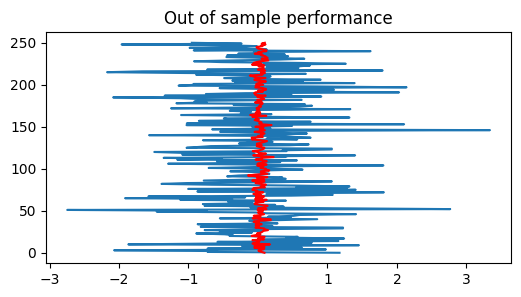

In [180]:
plt.plot(Y_dict, range(len(Y_dict)))
plt.plot(y_hat_dict, range(len(y_hat_dict)), 'r')
plt.title('Out of sample performance')
plt.show()

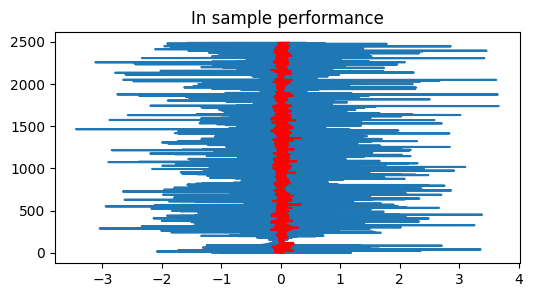

In [181]:
plt.plot(in_sample_Y_dict, range(len(in_sample_Y_dict)))
plt.plot(in_sample_y_hat_dict, range(len(in_sample_y_hat_dict)), 'r')
plt.title('In sample performance')
plt.show()

In [177]:
correlation, p_value = pearsonr(Y_dict, y_hat_dict)
print(f"Коэффициент корреляции Пирсона: {correlation}")
print(f"P-значение: {p_value}")

Коэффициент корреляции Пирсона: 0.004352379802185169
P-значение: 0.9452994465827942


In [182]:
correlation, p_value = pearsonr(in_sample_Y_dict, in_sample_y_hat_dict)
print(f"Коэффициент корреляции Пирсона: {correlation}")
print(f"P-значение: {p_value}")

Коэффициент корреляции Пирсона: 0.0844990613245109
P-значение: 2.4221961211878806e-05


In [183]:
correlation, p_value = spearmanr(Y_dict, y_hat_dict)
print(f"Коэффициент корреляции Спирмена: {correlation}")
print(f"P-значение: {p_value}")

Коэффициент корреляции Спирмена: 0.010444317966230316
P-значение: 0.8692213139470785


In [184]:
correlation, p_value = spearmanr(in_sample_Y_dict, in_sample_y_hat_dict)
print(f"Коэффициент корреляции Спирмена: {correlation}")
print(f"P-значение: {p_value}")

Коэффициент корреляции Спирмена: 0.07034450248585906
P-значение: 0.0004434559717479187


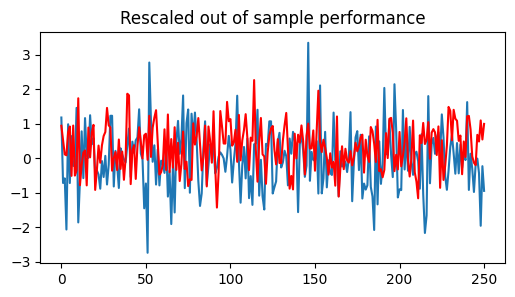

In [185]:
plt.plot(Y_dict)
plt.plot(y_hat_dict * 10, 'r')
plt.title('Rescaled out of sample performance')
plt.show()

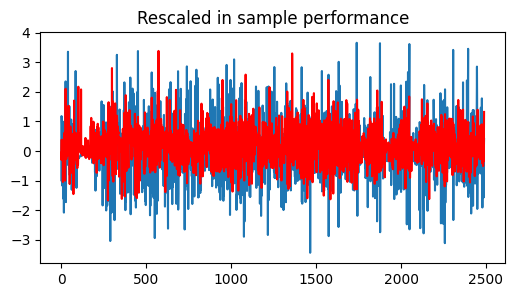

In [187]:
plt.plot(in_sample_Y_dict)
plt.plot(in_sample_y_hat_dict * 10, 'r')
plt.title('Rescaled in sample performance')
plt.show()

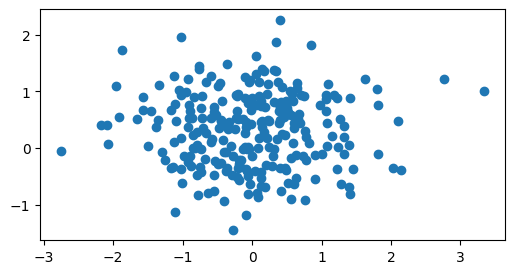

In [188]:
plt.plot(Y_dict, y_hat_dict * 10, linestyle="", marker="o")

In [189]:
pearsonr(Y_dict, y_hat_dict)

PearsonRResult(statistic=0.004352379802185169, pvalue=0.94529945)

In [190]:
spearmanr(Y_dict, y_hat_dict)

SignificanceResult(statistic=0.010444317966230316, pvalue=0.8692213139470785)

In [191]:
in_sample_Y_dict.shape

(2490,)